In [1]:
!pip install keras -q

# IMPORTA BIBLIOTECAS

In [2]:
# MANIPULAÇÃO DE DADOS
import pandas as pd
import numpy as np
from datetime import datetime

# VISUALIZAÇÃO DE DADOS
import matplotlib.pyplot as plt
import seaborn as sns

# TRANSFORMAÇÕES
from sklearn.preprocessing import StandardScaler

# PREPARAÇÃO TREINO E AVALIAÇÃO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, auc, confusion_matrix

# MODELOS UTILIZADOS
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.metrics import Precision, Recall, F1Score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import keras.ops as K
from keras.config import epsilon


# IMPORTAÇÃO DE DADOS

In [3]:
weather_aus = pd.read_csv("https://raw.githubusercontent.com/guilourenzo/master_degree_sin5007/refs/heads/main/DATA/weatherAUS.csv").dropna()
weather_aus["Date"] = pd.to_datetime(weather_aus["Date"], format="%Y-%m-%d")
weather_aus.sort_values(by="Date", inplace=True)


print(
    f"O dataset possui {weather_aus.shape[0]:,} instâncias (linhas) e {weather_aus.shape[1]:,} características (colunas)."
)

print(f"As características (colunas) do dataset são: {weather_aus.columns.to_list()}")

O dataset possui 56,420 instâncias (linhas) e 23 características (colunas).
As características (colunas) do dataset são: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


# FUNÇÕES PARA PRÉ-PROCESSAMENTO

## SEPARA TREINO E TESTE (80/20)

In [4]:
def split_data(df, target_column, train_size=0.8):
    n_train = int(len(df) * train_size)
    df_train = df.iloc[:n_train].reset_index(drop=True)
    df_test = df.iloc[n_train:].reset_index(drop=True)
    return df_train, df_test


## AJUSTA O FORMATO DO ALVO

In [5]:
def adjust_data_types(df):
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df["RainTomorrow"] = df.RainTomorrow.map({"Yes": 1, "No": 0})

    return df.sort_values(by="Date")


## CRIAÇÃO DE VARIÁVEIS AUXILIARES

In [6]:
def create_auxiliar_columns(df):
    def get_season(month_number):
        quarter = month_number % 12 // 3 + 1
        if quarter == 1:
            return "summer"

        if quarter == 2:
            return "autumn"

        if quarter == 3:
            return "winter"

        if quarter == 4:
            return "spring"

    # COLUNAS SELECIONADAS COM BASE NAS AVALIAÇÕES ANTERIORES
    df = df[
        [
            "Date",
            "MinTemp",
            "MaxTemp",
            "Rainfall",
            "Evaporation",
            "Sunshine",
            "WindGustDir",
            "WindGustSpeed",
            "WindDir3pm",
            "WindSpeed9am",
            "WindSpeed3pm",
            "Humidity9am",
            "Humidity3pm",
            "Pressure3pm",
            "Cloud9am",
            "Cloud3pm",
            "RainTomorrow",
        ]
    ]

    df["RangeTemp"] = df["MaxTemp"] - df["MinTemp"]

    df["month"] = df.Date.dt.month
    df["season"] = df["month"].apply(lambda month_number: get_season(month_number))

    time_encoded = pd.get_dummies(
        df[["month", "season"]],
        columns=["month", "season"],
        drop_first=True,
        prefix=["month", "season"],
        dtype=int,
    )

    # SEPARA AS VARIÁVEIS CATEGÓRICAS E NUMÉRICAS
    # CATEGORIZA AS VARIÁVEIS NECESSÁRIAS
    categorical_columns = pd.get_dummies(
        df.select_dtypes(include=["object", "datetime64"]),
        columns=["WindGustDir", "WindDir3pm"],
        drop_first=True,
        prefix=["WindGustDir", "WindDir3pm"],
        dtype=int,
    )

    numerical_columns = df.select_dtypes("number")

    df = pd.concat([numerical_columns, categorical_columns, time_encoded], axis=1)

    return df.drop(columns=["month", "Date", "season"]), {
        "numerical_columns": numerical_columns.drop(
            columns=["RainTomorrow", "month"]
        ).columns.to_list(),
        "categorical_columns": categorical_columns.drop(
            columns=["Date", "season"]
        ).columns.to_list(),
        "time_encoded": time_encoded.columns.to_list(),
    }


## APLICA AS TRANSFORMAÇÕES

In [7]:
def instance_transformations():
    scaler = StandardScaler()
    return scaler

In [8]:
def fit_transformmations(df, cols):
    scaler = instance_transformations()
    scaler.fit(df[cols])

    return scaler


In [9]:
def transform_data(df, cols, scaler):
    df[cols] = scaler.transform(df[cols])

    return df

# INICIO DO PRÉ-PROCESSAMENTO

### AJUSTA O TIPO DE DADO

In [10]:
weather_aus = adjust_data_types(weather_aus)

## SEPARA TREINO E TESTE (80/20)

In [11]:
df_train, df_test = split_data(weather_aus, "RainTomorrow")

## APLICAÇÕES SOBRE TREINO

### CRIA VARIÁVEIS AUXILIARES

In [12]:
df_train, columns_names = create_auxiliar_columns(df_train)

<ipython-input-6-5131b8425b02>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RangeTemp"] = df["MaxTemp"] - df["MinTemp"]
<ipython-input-6-5131b8425b02>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"] = df.Date.dt.month
<ipython-input-6-5131b8425b02>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

#### TRANSFORMA OS DADOS

In [13]:
scaler_full = fit_transformmations(
    df_train, columns_names["numerical_columns"]
)

In [14]:
df_train_full = transform_data(
    df_train, columns_names["numerical_columns"], scaler_full
)

## APLICAÇÕES SOBRE TESTE

### CRIA VARIÁVEIS AUXILIARES

In [15]:
df_test, _ = create_auxiliar_columns(df_test)

<ipython-input-6-5131b8425b02>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RangeTemp"] = df["MaxTemp"] - df["MinTemp"]
<ipython-input-6-5131b8425b02>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"] = df.Date.dt.month
<ipython-input-6-5131b8425b02>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

### TRANSFORMA OS DADOS

In [16]:
df_test_full = transform_data(
    df_test, columns_names["numerical_columns"], scaler_full
)

# PROCESSO DE MODELAGEM

## CRIAÇÃO DA JANELA TEMPORAL PARA O MODELO

In [17]:
def create_sequences(X, y, window_size=7):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size):
        X_windowed.append(X.iloc[i:(i + window_size)].values)
        y_windowed.append(y.iloc[i + window_size])
    X_windowed = np.array(X_windowed)
    y_windowed = np.array(y_windowed)
    return X_windowed, y_windowed

In [18]:
# EXTRACT FEATURES AND TARGET
X_train = df_train_full.drop(columns=['RainTomorrow'])
y_train = df_train_full['RainTomorrow']
X_test = df_test_full.drop(columns=['RainTomorrow'])
y_test = df_test_full['RainTomorrow']

In [19]:
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size=10)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size=10)

## CONSTRÓI O MODELO

In [20]:
def create_optimized_model(input_shape, learning_rate=0.001):
    model = Sequential([
        # First Bidirectional LSTM layer
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                         kernel_regularizer=l2(0.01)),
                     input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(32, activation='tanh', return_sequences=True,
                         kernel_regularizer=l2(0.01))),
        BatchNormalization(),
        Dropout(0.3),

        # Third Bidirectional LSTM layer
        Bidirectional(LSTM(16, activation='tanh', return_sequences=False,
                         kernel_regularizer=l2(0.01))),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Custom F1 metric
    def f1_metric(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0., 1.)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0., 1.)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0., 1.)))

        precision = true_positives / (predicted_positives + epsilon())
        recall = true_positives / (possible_positives + epsilon())

        f1_val = 2 * (precision * recall) / (precision + recall + epsilon())
        return f1_val

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy', Precision(), Recall(), f1_metric])

    return model

In [21]:
model = create_optimized_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## COMPILA O MODELO

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 128)             │          62,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 10, 64)              │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,489 (451.13 KB)

 Trainable params: 115,041 (449.38 KB)

 Non-trainable params: 448 (1.75 KB)

## TREINA O MODELO

In [23]:
callbacks = [
    EarlyStopping(monitor='val_f1_metric', patience=20, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_f1_metric', factor=0.5, patience=10,
                      min_lr=1e-6, mode='max', verbose=1),
    ModelCheckpoint('best_model_f1.keras',
                   monitor='val_f1_metric',
                   mode='max',
                   save_best_only=True,
                   verbose=1)
]

# Train model with class weights to handle imbalance
class_weights = dict(zip(
    np.unique(y_train_seq),
    len(y_train_seq) / (len(np.unique(y_train_seq)) * np.bincount(y_train_seq.astype(int)))
))

In [24]:
class_weights

{0: 0.6413769578441684, 1: 2.2683221071679904}

In [25]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,  # Increased batch size
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5271 - f1_metric: 18.9833 - loss: 3.5885 - precision: 0.2368 - recall: 0.5239
Epoch 1: val_f1_metric improved from -inf to 17.19651, saving model to best_model_f1.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5271 - f1_metric: 18.9834 - loss: 3.5866 - precision: 0.2368 - recall: 0.5239 - val_accuracy: 0.5671 - val_f1_metric: 17.1965 - val_loss: 0.9418 - val_precision: 0.2623 - val_recall: 0.5378 - learning_rate: 0.0010
Epoch 2/100
705/706 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5456 - f1_metric: 18.7382 - loss: 0.8487 - precision: 0.2465 - recall: 0.5274
Epoch 2: val_f1_metric did not improve from 17.19651
706/706 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.5456 - f1_metric: 18.7381 - loss: 0.8485 - precision: 0.2465 - recall: 0.5274 - val_accuracy: 0.6252 - val_f1_metric: 14.8137 - val_loss: 0.7043 - val_precision: 0.2779 - val_recall: 0.4444 - learning_rate: 0.0010
Epoch 3/100
705/706 ━━

# PREDIÇÃO E AVALIAÇÃO DE RESULTADOS

In [26]:
# LOAD BEST MODEL
model.load_weights('best_model_f1.keras')

In [35]:
y_pred = model.predict(X_test_seq)
y_pred_class = (y_pred > 0.5).astype(int)

353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [36]:
# Evaluate model using F1 Score, Accuracy, Recall, and Precision
f1 = f1_score(y_test_seq, y_pred_class)
accuracy = accuracy_score(y_test_seq, y_pred_class)
recall = recall_score(y_test_seq, y_pred_class)
precision = precision_score(y_test_seq, y_pred_class)

print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

F1 Score: 0.3526
Accuracy: 0.5671
Recall: 0.5378
Precision: 0.2623


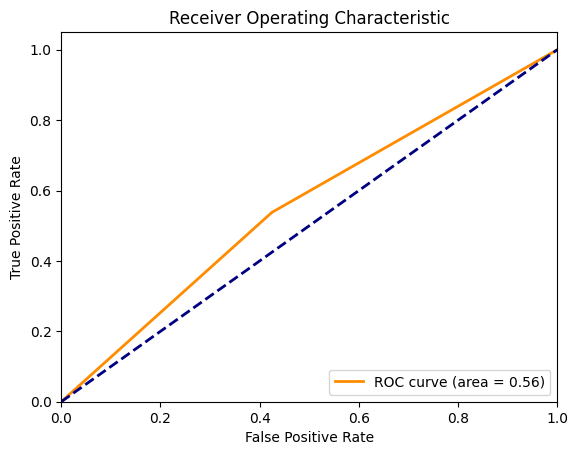

In [37]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_class)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

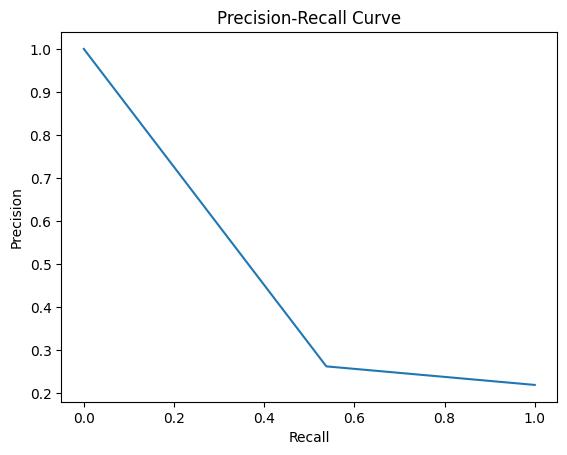

In [38]:
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_seq, y_pred_class)

# Plot Precision-Recall curve
plt.plot(recall_vals, precision_vals)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [39]:
# After predictions
roc_auc = roc_auc_score(y_test_seq, y_pred_class)
print(f'ROC-AUC Score: {roc_auc:.4f}')


ROC-AUC Score: 0.5566


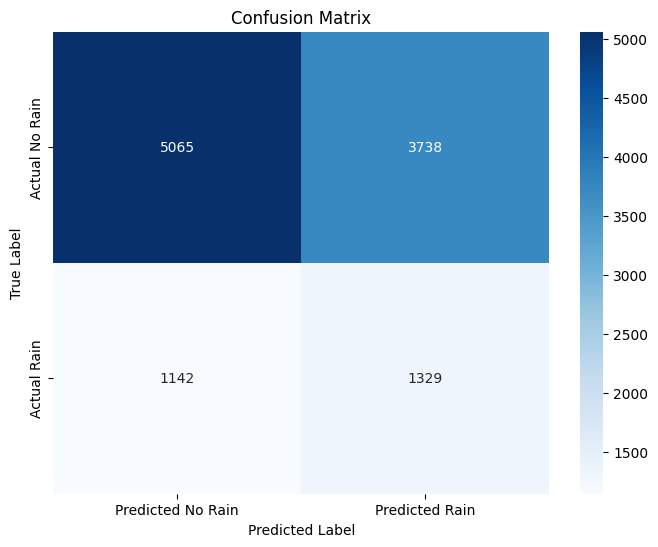

In [40]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_seq, y_pred_class)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No Rain', 'Predicted Rain'],
            yticklabels=['Actual No Rain', 'Actual Rain'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [41]:
# Create a DataFrame with true and predicted values
results_df = pd.DataFrame({'True': y_test_seq, 'Predicted': y_pred_class.flatten()})

# Calculate additional metrics within the DataFrame
results_df['Correct'] = results_df['True'] == results_df['Predicted']

# Classification Report
from sklearn.metrics import classification_report

classification_rep = classification_report(results_df['True'], results_df['Predicted'], output_dict=True)
classification_rep_df = pd.DataFrame(classification_rep).transpose()
classification_rep_df.loc['accuracy', 'support'] = classification_rep_df.loc['macro avg', 'support']

classification_rep_df

,precision,recall,f1-score,support
0,0.816014,0.575372,0.674883,8803.0
1,0.262285,0.537839,0.352613,2471.0
accuracy,0.567146,0.567146,0.567146,11274.0
macro avg,0.539150,0.556605,0.513748,11274.0
weighted avg,0.694650,0.567146,0.604249,11274.0


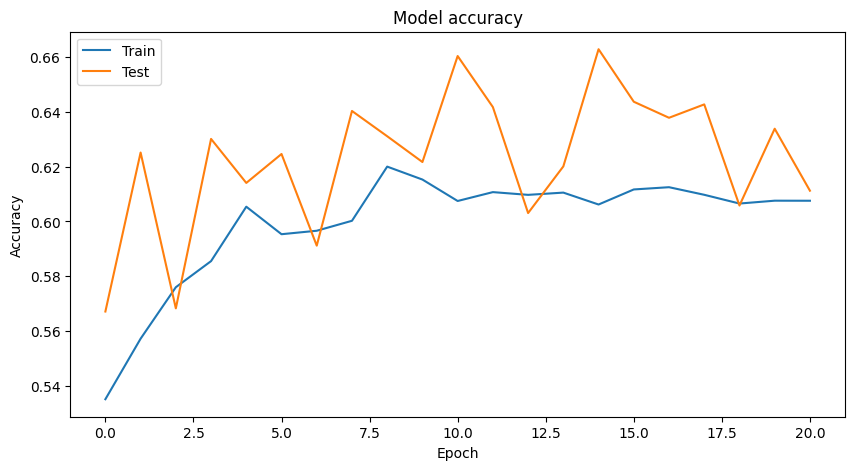

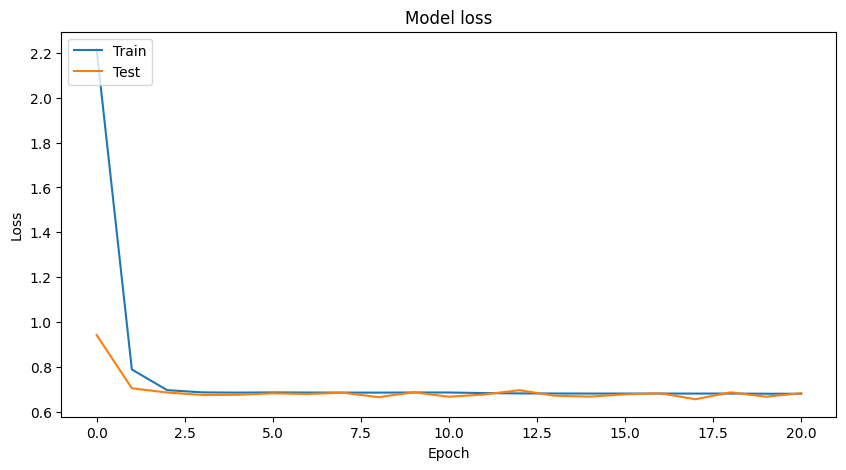

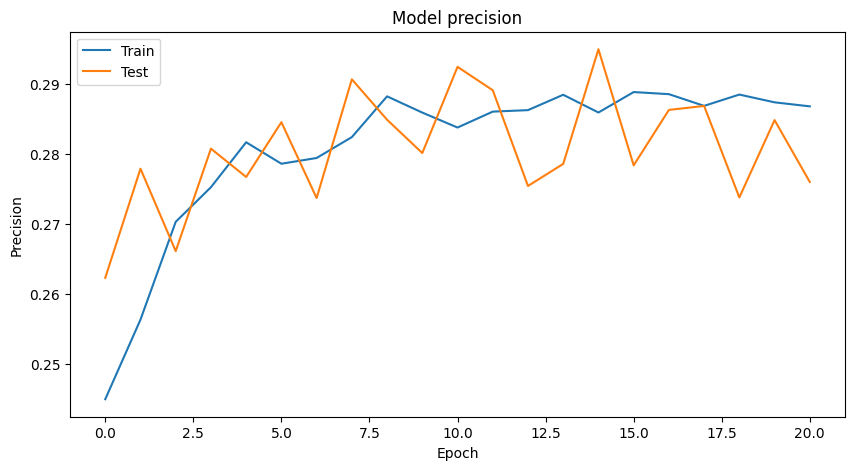

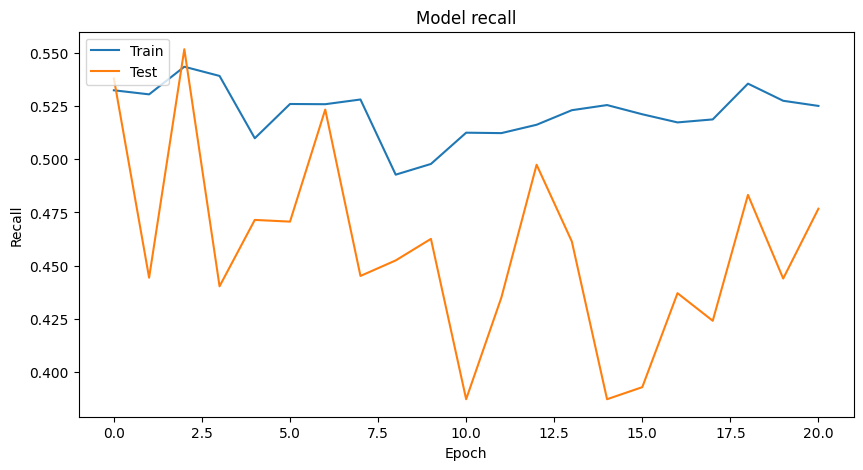

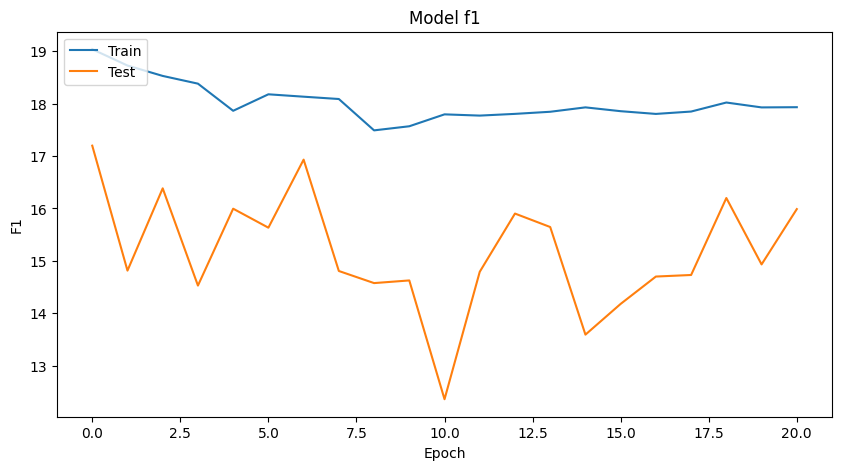

In [42]:
# prompt: crie um gráfico indicando as métricas do treinamento do modelo

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.figure(figsize=(10, 5))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.figure(figsize=(10, 5))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation f1 values
plt.figure(figsize=(10, 5))
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])
plt.title('Model f1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()